## Constructing Posterior

We further assume that our interest is on the 9 interior nodes with $\Delta x = \Delta y = 0.3$. Thus the observational data is obtained by using 9 various cartesian points $\{x_m; \ m=\Delta x, 2\Delta x, 3\Delta x\}$  and $\{y_n; \ n=\Delta y, 2\Delta y, 3\Delta y\}$. This makes the inverse problem 9 dimentional and it follows 
$$
Y_{i} = T(x_m, y_n;\ k) + \eta_i ,\quad i=1,2 \ldots,9.
$$

You can generate datum $Y$ by calling UM-Bridge model, then construct **log posterior** by using **log prior** and **log likelihood**.

In [1]:
# umbridge client
import umbridge
import numpy as np

model = umbridge.HTTPModel("http://localhost:4242", "forward")
data = np.array(model([[200]]))
print(data)

[[1382.46033368 1749.97010321 1382.46033368 1678.85883617 2160.2309299
  1678.85883617 1309.82539075 1661.44619927 1309.82539075]]


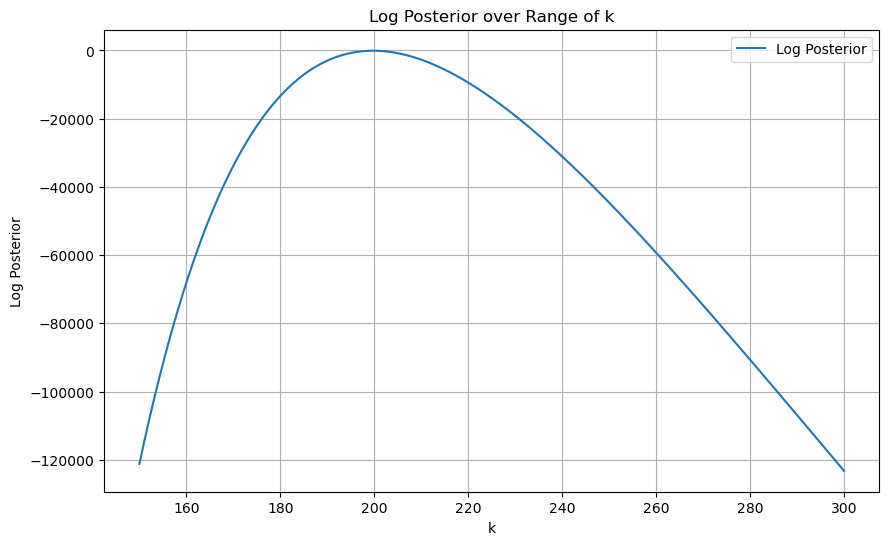

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from mpl_toolkits.mplot3d import axes3d
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import numpy
from scipy.linalg import block_diag
from scipy import linalg


# parameters
var_prior = 20
mu_prior = 200
var_noise = 10
mu_noise = 0

# defining log-prior distribution  
def g(k):
    log_prior_pdf = -0.5*np.log(2*np.pi*var_prior) - 0.5*(((k - mu_prior)**2)/(var_prior))
    return log_prior_pdf


# defining likelihood function at specific points (xi, yi)
T_obs = (data + np.random.normal(mu_noise, var_noise, data.shape)).flatten()
d = len(T_obs)

def f(k):
    T_model_array= np.array(model([[k]]))
    T_model = T_model_array.flatten()   #during MCMC candidate values for k will be proposed and for each k, the forward model will be solved 
    cov_matrix = var_noise*np.identity(d)
    inverse_cov_matrix = np.linalg.inv(cov_matrix)
    diff = T_obs - T_model
    log_likelihood_pdf = -0.5*d*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(cov_matrix)) - 0.5* (diff.T @ (inverse_cov_matrix) @ diff)
    return log_likelihood_pdf


# constructing posterior 
def p(k):
    log_post_pdf = g(k) + f(k) 
    return log_post_pdf


# defining the range of k values to evaluate the posterior
k_values = np.linspace(150, 300, 400)

# computing the log posterior for each k value
log_posteriors = np.array([p(k) for k in k_values])

# plotting the log posterior
plt.figure(figsize=(10, 6))
plt.plot(k_values, log_posteriors, label='Log Posterior')
plt.xlabel('k')
plt.ylabel('Log Posterior')
plt.title('Log Posterior over Range of k')
plt.legend()
plt.grid(True)
plt.show()






## Markov Chain Monte Carlo (MCMC)

Since the direct sampling from the posterior distribution is not possible, we are utilizing Markov Chain Monte Carlo (MCMC) method. One of the popular algorithms for MCMC is Metropolis Hastings algorithm.

To apply this algorithm, we need to define proposal distribution which generates new candidate values $k'$ based on the current state. In our case, suppose that initial state is $k_0=200$ and we are using Gaussian proposal distribution $q(k_j, \ k')$ with mean $k_j$ and variance $\sigma_{proposal}^2 = 0.1$. Thereafter, accaptance probabilty can be computed. 

**Remark.** We are working with the logarithm of likelihood and the prior. Therefore, when we calculate the acceptance probability, we need to consider the log scale transformation.

Iteration  Proposed k                Accepted   log_u      log_alpha 
0          200.04967141530113        False      -0.31198   -0.73219  
1          199.98617356988288        True       -0.51306   0.00000   
2          199.96275823241055        True       -2.84587   0.00000   
3          199.93934453671562        True       -0.14367   0.00000   
4          200.09726581826635        True       -3.88322   -2.27111  
5          200.17400929118165        False      -0.03055   -1.59626  
6          200.05031837967286        True       -1.70471   0.00000   
7          200.10457438403145        True       -1.69606   -0.95600  
8          200.12877061118806        True       -0.83946   -0.47823  
9          199.93744258672228        True       -1.23364   0.00000   


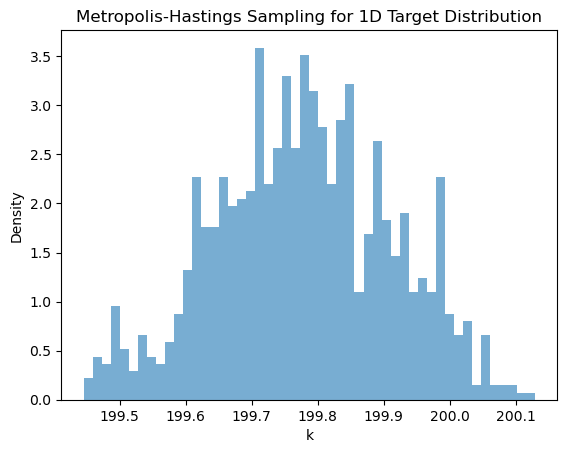

In [15]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import arviz as az

np.random.seed(42)

# Define the proposal distribution
def proposal_distribution(k, var=.1):
    return np.random.normal(k, var)

# Metropolis-Hastings algorithm
def metropolis_hastings(initial_state, num_samples, p, proposal_distribution, var=.1):
    samples = []  # List to store the samples
    k = initial_state  # Start from the initial state
    acceptances = []

    for j in range(num_samples):
        # Given the current state x_j = x, draw a realization x' from Q(x, .)
        k_prime = proposal_distribution(k, var)
        
        # Compute the acceptance probability α(x, x')
        log_alpha = min(0, p(k_prime) - p(k))
        
        # Draw an independent sample u_j+1 ~ uniform[0, 1]
        log_u = np.log(np.random.uniform(0, 1))
        
        if log_u <= log_alpha:
            k = k_prime  # Accept the new state
            accepted = True
        else:
            accepted = False

        samples.append(k)  # Store the current state (whether accepted or not)

        # Store acceptance info for the first 10 iterations
        if j < 10:
            acceptances.append((k_prime, accepted, log_u, log_alpha))

    return np.array(samples), acceptances

# Parameters
initial_state = 200
num_samples = 1000

# Run Metropolis-Hastings algorithm
samples, acceptances = metropolis_hastings(initial_state, num_samples, p, proposal_distribution)

# Print acceptance info for the first 10 iterations
print(f"{'Iteration':<10} {'Proposed k':<25} {'Accepted':<10} {'log_u':<10} {'log_alpha':<10}")
for i, (k_prime, accepted, log_u, log_alpha) in enumerate(acceptances):
    print(f"{i:<10} {str(k_prime):<25} {str(accepted):<10} {log_u:<10.5f} {log_alpha:<10.5f}")

# Plot samples
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Samples')
plt.title('Metropolis-Hastings Sampling for 1D Target Distribution')
plt.xlabel('k')
plt.ylabel('Density')
plt.show()

As in `MCMC Example`, we can use `ArviZ` package to obtain the following graphs. 

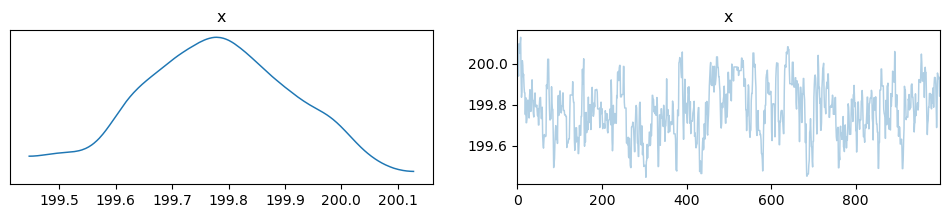

In [16]:
# Use ArviZ to create an InferenceData object
import arviz as az
az_data = az.from_dict(posterior={'x': samples})

# Plot the results using ArviZ
az.plot_trace(az_data)
plt.show()

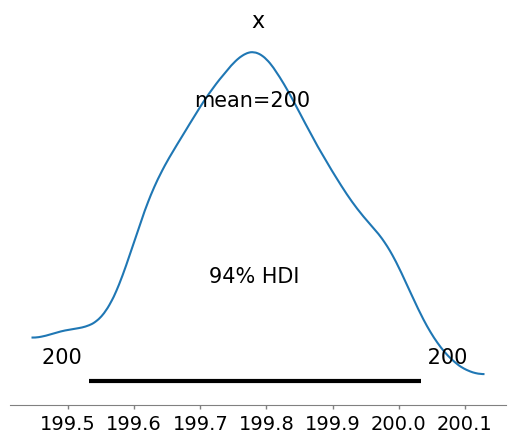

In [17]:
# Plot the posterior density using ArviZ
az.plot_posterior(az_data)
plt.show()

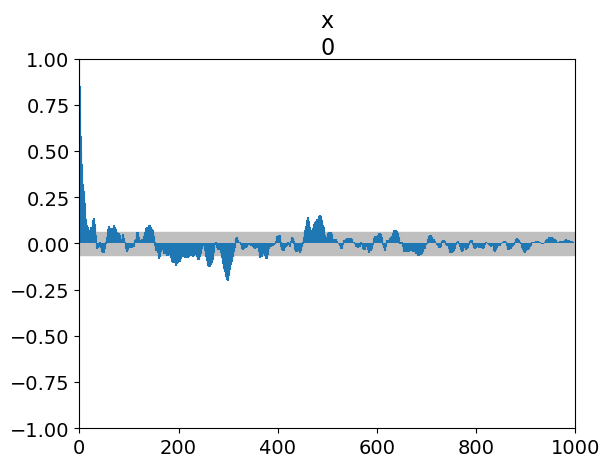

In [18]:
# Plot the autocorrelation of the samples
az.plot_autocorr(az_data, max_lag=1000)#
plt.show()